## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from dask.distributed import performance_report

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(83cbec2e, 'tcp://127.0.0.1:57610', workers=4, threads=12, memory=64.00 GiB)

In [5]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57610,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57622,Total threads: 3
Dashboard: http://127.0.0.1:57625/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:57613,


In [6]:
# partitions in the generated dataframe
npartitions = 50

In [7]:
n = 10_000
names = [
    "".join(random.choices(string.ascii_letters + string.digits + " ", k=random.randint(10, 100)))
    for _ in range(n)
] 

@delayed(pure=False)
def make_partition(dtype):
    nrows = 1_000_000
    data = [random.choice(names) for _ in range(nrows)]
    df = pd.DataFrame({"name": pd.Series(data, dtype=dtype)})
    return df

In [8]:
def get_ddf(persist=False):
    meta = pd.DataFrame({"name": pd.Series([], dtype=object)})
    ddf = dd.from_delayed(
        [make_partition(object) for i in range(npartitions)],
        meta=meta
    )
    return ddf.persist() if persist else ddf

In [9]:
def get_ddf2(persist=False):
    meta = pd.DataFrame({"name": pd.Series([], dtype="string[pyarrow]")})
    ddf = dd.from_delayed(
        [make_partition("string[pyarrow]") for i in range(npartitions)],
        meta=meta
    )
    return ddf.persist() if persist else ddf

## Memory usage

In [10]:
from dask.utils import format_bytes

In [11]:
ddf = get_ddf(True)

In [12]:
ddf.size.compute()

50000000

In [13]:
ddf.dtypes

name    object
dtype: object

In [14]:
ddf.head(10)

,name
0,M117QzSt0797QEXxLSGscHjrsyCuyoUse53LKACmVSpzIR...
1,O6dobLAnQsTsLuxh
2,nxhRJsrqeUrkjRsjLg7YwHIrXolIVZ4CTN 6PfzAkNATEl...
3,F63KpYDbkexYQbddQoci3Lp4mGZk6 rNh70hMNKWCajGm ...
4,iMvm8IPo7DL8s1wntE5W4vjYk58vaL2f2d2wGFapEWKJVQ...
5,BkcQ2KGBwO4fp5iCMjT7MaT9LvhS5dNRYPNi59XUDMypgt...
6,WbK R5RCNqtu3zYJ5iU3b0nfnW3po69EKvq8gsZRj1zZ9B...
7,flmZAQo7p7xURsdyWKSMyGE8UlYzkWSmNnehfYYmM9YiCg...
8,ZTMW21Folan83
9,vHqz8glyydHnyyvDDQcBmRyDfuIY oNoyzBA9krv t


In [15]:
format_bytes(ddf.memory_usage(deep=True).sum().compute())

'5.20 GiB'

In [16]:
memory_usage_object = ddf.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_object

0     7.63 MiB
1     7.63 MiB
2     7.63 MiB
3     7.63 MiB
4     7.63 MiB
5     7.63 MiB
6     7.63 MiB
7     7.63 MiB
8     7.63 MiB
9     7.63 MiB
10    7.63 MiB
11    7.63 MiB
12    7.63 MiB
13    7.63 MiB
14    7.63 MiB
15    7.63 MiB
16    7.63 MiB
17    7.63 MiB
18    7.63 MiB
19    7.63 MiB
20    7.63 MiB
21    7.63 MiB
22    7.63 MiB
23    7.63 MiB
24    7.63 MiB
25    7.63 MiB
26    7.63 MiB
27    7.63 MiB
28    7.63 MiB
29    7.63 MiB
30    7.63 MiB
31    7.63 MiB
32    7.63 MiB
33    7.63 MiB
34    7.63 MiB
35    7.63 MiB
36    7.63 MiB
37    7.63 MiB
38    7.63 MiB
39    7.63 MiB
40    7.63 MiB
41    7.63 MiB
42    7.63 MiB
43    7.63 MiB
44    7.63 MiB
45    7.63 MiB
46    7.63 MiB
47    7.63 MiB
48    7.63 MiB
49    7.63 MiB
dtype: object

In [17]:
ddf2 = get_ddf2(True)

In [18]:
ddf2.dtypes

name    string[pyarrow]
dtype: object

In [19]:
format_bytes(ddf2.memory_usage(deep=True).sum().compute())

'2.73 GiB'

In [20]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0     55.95 MiB
1     55.91 MiB
2     55.95 MiB
3     55.92 MiB
4     55.97 MiB
5     55.97 MiB
6     55.98 MiB
7     55.90 MiB
8     55.93 MiB
9     55.96 MiB
10    55.96 MiB
11    55.96 MiB
12    55.95 MiB
13    55.97 MiB
14    55.94 MiB
15    55.92 MiB
16    55.94 MiB
17    55.90 MiB
18    55.94 MiB
19    55.92 MiB
20    55.93 MiB
21    55.96 MiB
22    55.95 MiB
23    55.92 MiB
24    55.94 MiB
25    55.92 MiB
26    55.98 MiB
27    55.93 MiB
28    55.96 MiB
29    55.94 MiB
30    55.93 MiB
31    55.96 MiB
32    55.92 MiB
33    55.94 MiB
34    55.90 MiB
35    55.90 MiB
36    55.95 MiB
37    55.96 MiB
38    55.92 MiB
39    55.89 MiB
40    55.92 MiB
41    55.93 MiB
42    55.92 MiB
43    55.97 MiB
44    55.91 MiB
45    55.96 MiB
46    55.92 MiB
47    55.95 MiB
48    55.91 MiB
49    55.98 MiB
dtype: object

## Running time

In [40]:
client.restart();

2023-03-30 11:59:18,455 - distributed.nanny - WARNING - Restarting worker
2023-03-30 11:59:18,457 - distributed.nanny - WARNING - Restarting worker
2023-03-30 11:59:18,475 - distributed.nanny - WARNING - Restarting worker
2023-03-30 11:59:18,476 - distributed.nanny - WARNING - Restarting worker


In [41]:
ddf = get_ddf(True)

In [42]:
wait(ddf);

In [44]:
%timeit -r 5 -n 2 ddf.name.unique().compute()

The slowest run took 98.66 times longer than the fastest. This could mean that an intermediate result is being cached.
248 ms ± 228 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [45]:
%timeit -r 5 -n 2 ddf.groupby("name").count().compute()

The slowest run took 84.80 times longer than the fastest. This could mean that an intermediate result is being cached.
277 ms ± 250 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [46]:
%timeit -r 5 -n 2 ddf.name.str.startswith("a").compute()

1.9 s ± 19.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [48]:
%timeit -r 5 -n 2 ddf.name.str.len().compute()

2.03 s ± 7.22 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [49]:
client.restart();

2023-03-30 12:00:50,146 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:00:50,167 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:00:50,168 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:00:50,173 - distributed.nanny - WARNING - Restarting worker


In [50]:
ddf2 = get_ddf2(True)

In [51]:
wait(ddf2);

In [53]:
%timeit -r 5 -n 2 ddf2.name.unique().compute()

The slowest run took 24.02 times longer than the fastest. This could mean that an intermediate result is being cached.
79.1 ms ± 87 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [54]:
%timeit -r 5 -n 2 ddf2.groupby("name").count().compute()

396 ms ± 7.49 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [55]:
%timeit -r 5 -n 2 ddf2.name.str.startswith("a").compute()

263 ms ± 16.6 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [56]:
%timeit -r 5 -n 2 ddf2.name.str.len().compute()

698 ms ± 14.3 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Create memory samplers and store benchmarks

In [23]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()

In [24]:
report_dir = "performance/local4workers2"

In [25]:
import time

## Benchmark 1

In [26]:
client.restart();

2023-03-30 12:10:09,199 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:09,210 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:09,211 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:09,212 - distributed.nanny - WARNING - Restarting worker


In [27]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).name.unique().compute()
            time.sleep(0.2)

In [28]:
client.restart();

2023-03-30 12:10:17,641 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:17,652 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:17,653 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:17,654 - distributed.nanny - WARNING - Restarting worker


In [29]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).name.unique().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

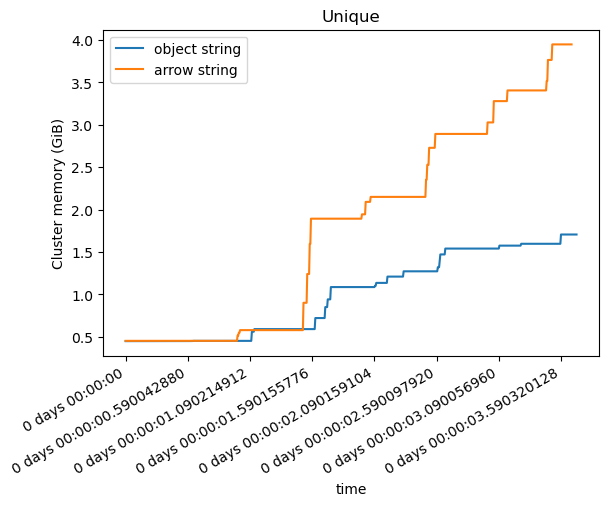

In [30]:
ms1.plot(align=True, title="Unique")

## Benchmark 2

In [31]:
client.restart();

2023-03-30 12:10:31,476 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:31,501 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:31,510 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:31,511 - distributed.nanny - WARNING - Restarting worker


In [32]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-count.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).groupby("name").count().compute()
            time.sleep(0.2)

In [33]:
client.restart();

2023-03-30 12:10:40,845 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:40,866 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:40,867 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:40,868 - distributed.nanny - WARNING - Restarting worker


In [34]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-count.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).groupby("name").count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

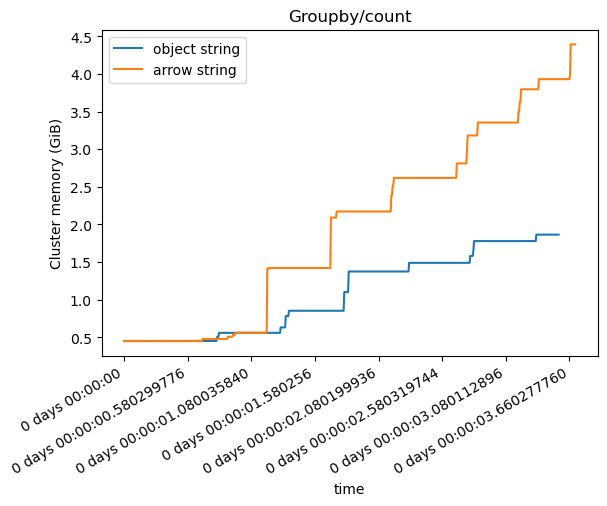

In [35]:
ms2.plot(align=True, title="Groupby/count")

## Benchmark 3

In [44]:
client.restart();

2023-03-30 12:49:27,077 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:49:27,090 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:49:27,092 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:49:27,100 - distributed.nanny - WARNING - Restarting worker


In [45]:
# 3
with performance_report(filename=f"{report_dir}/3-object-startswith.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).name.str.startswith("a").compute()
            time.sleep(0.2)

In [46]:
client.restart();

2023-03-30 12:50:11,198 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:11,216 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:11,217 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:11,218 - distributed.nanny - WARNING - Restarting worker


In [47]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-startswith.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).name.str.startswith("a").compute()
            time.sleep(0.2)

<Axes: title={'center': 'String startswith'}, xlabel='time', ylabel='Cluster memory (GiB)'>

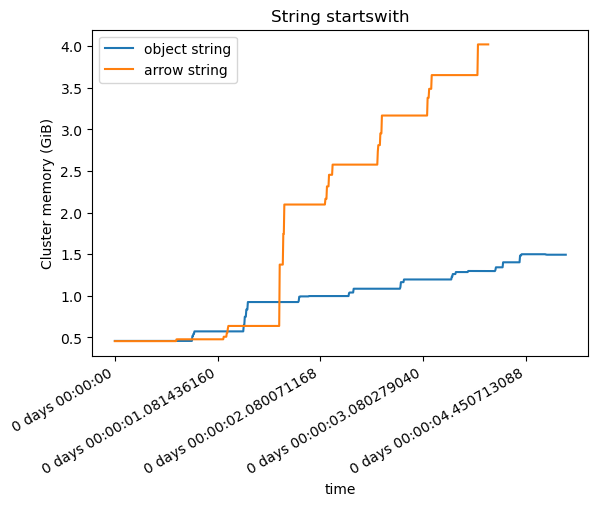

In [48]:
ms3.plot(align=True, title="String startswith")

## Benchmark 4

In [49]:
client.restart();

2023-03-30 12:50:30,047 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:30,062 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:30,066 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:30,067 - distributed.nanny - WARNING - Restarting worker


In [50]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms4.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.str.len().compute()
            time.sleep(0.2)

AttributeError: 'DataFrame' object has no attribute 'store_and_fwd_flag'

In [62]:
client.restart();

2023-03-29 17:21:09,466 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:21:09,495 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:21:09,496 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:21:09,497 - distributed.nanny - WARNING - Restarting worker


In [63]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms4.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2().store_and_fwd_flag.str.len().compute()
            time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

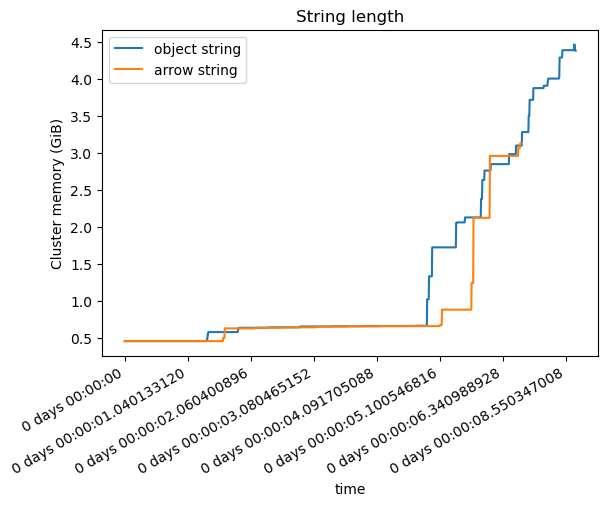

In [64]:
ms4.plot(align=True, title="String length")

In [17]:
client.close()

In [18]:
cluster.close()